In [131]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image_path = "ktp_training_photos/train/IMG_7276.HEIC"
# image_path = "ktp_training_photos/validate/IMG_7293.HEIC"

import pillow_heif

heif_file = pillow_heif.open_heif(image_path, convert_hdr_to_8bit=False, bgr_mode=False)
orig = np.asarray(heif_file)
img = cv.cvtColor(orig, cv.COLOR_RGB2GRAY)

img.shape

(4032, 3024)

In [133]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

MIN_MATCH_COUNT = 10
img1 = cv.imread('template.png')[..., ::-1] # queryImage
img1 = cv.imread('template2.jpeg')[..., ::-1] # queryImage
img1 = cv.imread('template3.png',cv.IMREAD_GRAYSCALE)
img2 = img.copy()

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 7)
search_params = dict(checks = 20)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [134]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape[0], img1.shape[1]
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])
    dst = cv.perspectiveTransform(pts.reshape(-1,1,2),M)
    print(M.shape)
    pts1 = dst[:,0,:]
    base_size = 16*50
    (w_final,h_final) = 1.4*base_size, base_size
    final_pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ])
    M2 = cv.getPerspectiveTransform(pts1,final_pts)
    dst2 = cv.warpPerspective(orig,M2,(w,h))

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

(3, 3)


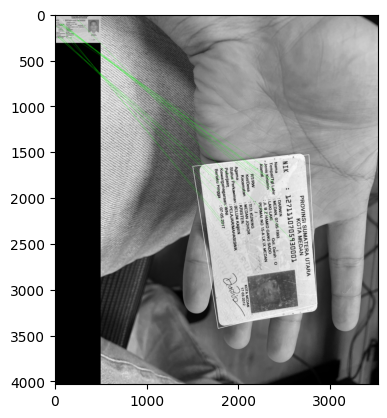

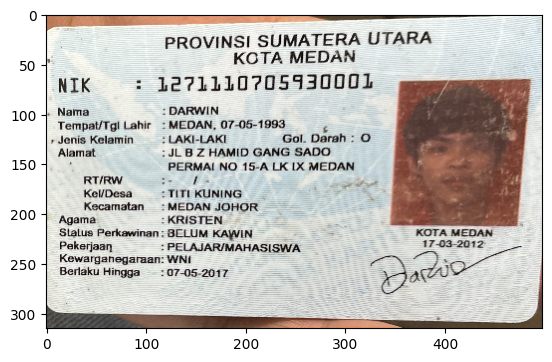

(<matplotlib.image.AxesImage at 0x176411510>, None)

In [136]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
 singlePointColor = None,
 matchesMask = matchesMask, # draw only inliers
 flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
# plt.imshow(img1),plt.show()
plt.imshow(img3),plt.show()
plt.imshow(dst2),plt.show()

In [36]:
cx = 892
cy = 2352
w = 1185
h = 1793

def centerwh2bbox(x,y,w,h):
    x3, y3 = x-w/2, y-h/2  # up left
    x4, y4 = x-w/2, y+h/2  # up right
    x1, y1 = x+w/2, y-h/2  # bottom left
    x2, y2 = x+w/2, y+h/2  # bottom right
    return [[x1, y1], [x2, y2],[x3, y3],[x4, y4]]

[[x1, y1], [x2, y2],[x3, y3],[x4, y4]]= centerwh2bbox(cx,cy,w,h)
[[x1, y1], [x2, y2],[x3, y3],[x4, y4]] = [[1608, 1603],[1322,3088],[465,1442],[294, 3119]]

(<Axes: title={'center': 'Output'}>,
 Text(0.5, 1.0, 'Output'))

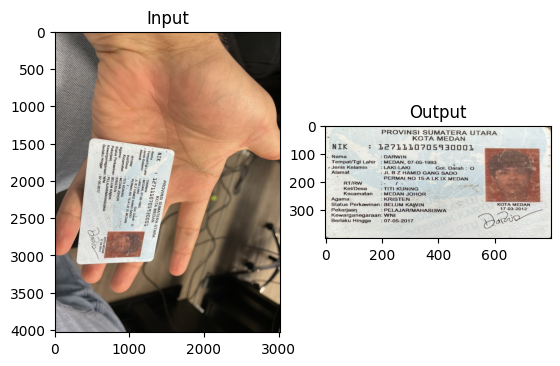

In [39]:
rows,cols,ch = img.shape
pts1 = np.float32([[x1, y1], [x2, y2],[x3, y3],[x4, y4]])
n = 400
pts2 = np.float32([[0,0],[2*n,0],[0,n],[2*n,n]])
M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img,M,(2*n,n))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')